In [3]:
using Symbolics
using LinearAlgebra
using Latexify
using Plots

## Fluídos Conformes

Código para testear la estabilidad alrededor de una solución de equilibrio.

Las ecuaciones son:

$(\zeta^a, \zeta^{ab})$ -> $f^j = (\mu, v, x_i)$ -> $(-1,0,0,0,0)$

$$
\partial_t c^j = \partial_i F^{ij}(f) + I^j(f) = \frac{\partial F^{ij}}{\partial f^k}\partial_i f^k
$$

$$
c^j = C^j(f) = (e, S, c_i)
$$

Lo que hacemos es tomar el jacobiano del flujo,

$\frac{\partial F^i}{\partial f^j}$ donde $f^j$ son las variables no conservativas para las cuales tenemos las expresiones del Flujo. 
A estas las multiplicamos por $[\frac{\partial c^k}{\partial f^j}]^{-1}$.
Tenemos así 

$$
P^{il}{}_j := \frac{\partial F^{il}}{\partial c^j} = \frac{\partial F^{il}}{\partial f^k}\frac{\partial f^k}{\partial c^j}.
$$

Evaluamos todo en el vector $(-1,0,0,0,0)$ o sea estamos en el frame con velocidad cero y todas las variables fuera de equilibrio también cero.

Lo mismo hacemos con la fuente. 

$$
II^i{}_j = \frac{\partial I^i}{\partial f^k} \frac{\partial f^k}{\partial c^j}
$$

Tenemos así el sistema linearizado en el punto de equilibrio en las variables conservativas. Multiplicamos $P^i{}_j$ por un número complejo cualquiera y para todos ellos los autovalores debieran tener parte real negativa o nula. Pero no es así...


Alternativamente podemos diferenciar $c^i$ con respecto a los $f^j$ para obtener,

$$
\partial_t c^j = \frac{\partial c^j}{\partial f^i} \partial_t f^i
$$

y por lo tanto,

$$
\partial_t f^i = \frac{\partial c^j}{\partial f^i}^{-1} \frac{\partial F^{lj}}{\partial f^k}\partial_l f^k := \tilde{P}^i{}_k\partial_l f^k
$$

A las que simplemente sumamos el término $\frac{\partial c^j}{\partial f^i}^{-1}\frac{\partial I^j}{\partial f^k}$ para tener el sistema linearizado con respecto a las $f^i$.

In [4]:
function Flux(flu,par)
    χ = par
    #flux = zeros(5)
    μ = flu[1]  
    T = (abs(μ))^(-1//2) 
    v = flu[2]
    x1 = flu[3]
    x2 = flu[4]
    x3 = flu[5]
    χ₀ = χ[1]
    χ₁ = χ[2]
    χ₂ = χ[3]
    γ = (1 - v^2)^(-1//2)
    τ = 2χ₁ * x3 * T / (γ*μ^3) + 24χ₂*(1//2*(1-v^2)x3^2 + 14//3 * x2^2 + 7/5*(1-v^2)x1*x3)/μ^5
    ρ = -6χ₀ / μ^2 - 6χ₁*x1/(γ * μ^4 * T) + 42χ₂*(6//5 *x1^2 + 10γ^2*x2^2 + 3//2*(v^2-1)^2*x3^2)/(μ^5 * γ^2)
#    Q = 10χ₀ * x2 * T / μ^3 + 168χ₂ * x2 * (x1 - (v^2 - 1)x3)/(γ * μ^5)
    Q = 10χ₁ * x2 * T / μ^3 + 168χ₂ * x2 * (x1 - (v^2 - 1)x3)/(γ * μ^5)
    #flux[1] = 4//3 * ρ*γ^2*v + γ*Q*(1+v^2)+ τ*v
    #flux[2] = 4//3 * ρ*(γ^2*v^2 + 1//4) + 2v*γ*Q + τ
    #flux[3] = χ₁*γ*v*(6*γ^2 - 1)/μ^3/T - 12χ₂*(v*(6γ^2 - 1)*x1 + (6γ^2*(2v^2 + 1)-1)*x2 + v*(v^2+2)*x3)/μ^4
    #flux[4] = χ₁*γ*(6γ^2*v^2+1)/μ^3/T - 12χ₂*((6γ^2*v+1)*x1 + v*(6γ^2*(1+v^2)+1)*x2 + (2v^2+1)*x3)/μ^4
    #flux[5] = 3χ₁*γ*v*(2γ^2*v^2+1)/μ^3/T - 12χ₂*(v*(6γ^2*v^2+3)*x1 +3*(1+6γ^2*v^2)*x2 + 3v*x3)/μ^4
    #return -flux[:]
    return [4//3 * ρ*γ^2*v + γ*Q*(1+v^2)+ τ*v; 
            4//3 * ρ*(γ^2*v^2 + 1//4) + 2v*γ*Q + τ;
            χ₁*γ*v*(6*γ^2 - 1)/μ^3/T   - 12χ₂*(v*(6γ^2 - 1)*x1   + (6γ^2*(2v^2 + 1)-1)*x2 + v*(v^2+2)*x3)/μ^4;
            #χ₁*γ*(6γ^2*v^2+1)/μ^3/T    - 12χ₂*((6γ^2*v+1)*x1     + v*(6γ^2*(1+v^2)+1)*x2  + (2v^2+1)*x3)/μ^4;
            χ₁*γ*(6γ^2*v^2+1)/μ^3/T    - 12χ₂*((6γ^2*v^2+1)*x1     + v*(6γ^2*(2+v^2)+1)*x2  + (2v^2+1)*x3)/μ^4;
            #χ₁*γ*(6γ^2*v^2+1)/μ^3/T    - 12χ₂*((6γ^2*v^2+1)*x1     + v*(6γ^2*(1+v^2)+1)*x2  + (2v^2+1)*x3)/μ^4;    
            3χ₁*γ*v*(2γ^2*v^2+1)/μ^3/T - 12χ₂*(v*(6γ^2*v^2+3)*x1 + 3*(1+6γ^2*v^2)*x2      + 3v*x3)/μ^4]
end

Flux (generic function with 1 method)

In [5]:
@variables f[1:5], c[1:5], p[1:3]#, fl[1:5]

JFS = Symbolics.jacobian(Flux(f,p),f);
JF_exp = Symbolics.build_function(JFS, f, p);
JFac = eval(JF_exp[1]);

In [6]:
include("inversion_ext.jl");

In [7]:
P(flu,c,p) =  JFac(flu,p)*inv(Jac(flu,c,p))
PT(flu,c,p) = inv(Jac(flu,con,par_f))*JFac(flu,par_f)

PT (generic function with 1 method)

In [8]:
flu=[-1.;0.99;0;0;0];
con = F(flu,zeros(5), p);
par_f = [-1,-0,-2]
P(flu,c,par_f)

5×5 Matrix{Float64}:
 -2.27669e-14  1.0       2.89417      -5.81743  2.92326
 -0.960592     1.96049   2.89403      -5.81714  2.92311
  0.0          0.0       1.63923e-13   1.0      4.9396e-15
  0.0          0.0      -0.979806      1.96946  0.0103469
  0.0          0.0      -1.94031       2.91018  0.0301364

In [9]:
flu=[-1.;-0.;0;0;0];
con = F(flu,zeros(5), p);
par_f = [-1,-0,-2]
eigvals(P(flu,con,par_f))

5-element Vector{Float64}:
 -0.7745966692414833
 -0.5773502691896256
  0.0
  0.5773502691896258
  0.7745966692414834

In [10]:
flu=[-1.;-0.001;0;0;0;0];
par_f = [-1.,0.,-2.]
con = F(flu,zeros(5), par_f);
eigvals(PT(flu,con,par_f))

5-element Vector{Float64}:
 -0.7751961789434892
 -0.5780165511782069
 -0.000999999999999964
  0.576683217400429
  0.7739961783834896

In [16]:
N = 1000
par_f = [-1,0.2,-20]
#par_f = [-1,-0.5,-20]
E = zeros(5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/N/1
    flu[2] = v[i]
    E[:,i]=eigvals(P(flu,con,par_f))
    if any(E[:,i].>1.)
        println(E[:,i], v[i])
    end
end

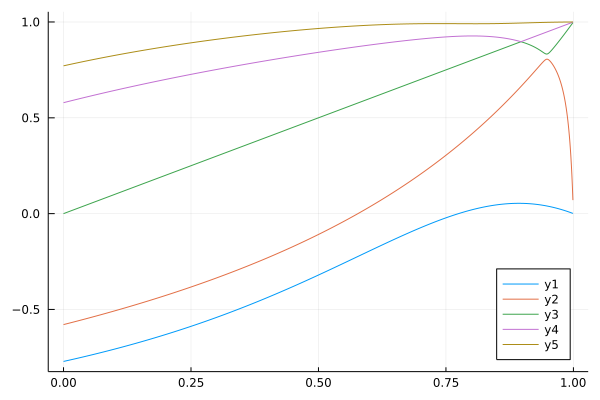

In [17]:
plot(v,E[1,:])
plot!(v,E[2,:],
legend=:bottomright)
plot!(v,E[3,:])
plot!(v,E[4,:])
plot!(v,E[5,:])

In [11]:
Eu(flu,con,par_f) = P(flu,con,par_f)[1:2,1:2]

Eu (generic function with 1 method)

In [12]:
N = 100
par_f = [-1,-0,-2]
Eul = zeros(2,N)
for i in 1:N
    v = (i-1)/N
    flu[2] = v
    Eul[:,i]=eigvals(Eu(flu,con,par_f))
end

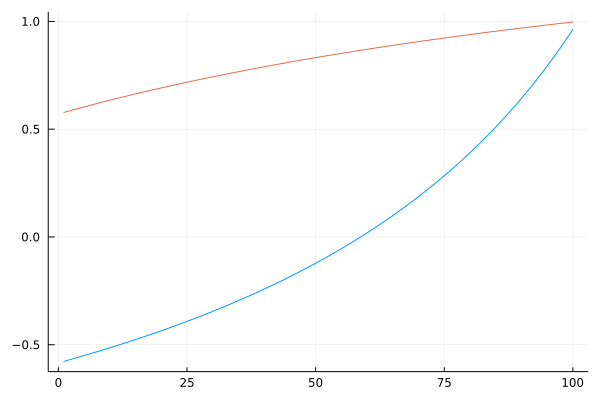

In [13]:
plot(Eul[1,:],
    label=false)
plot!(Eul[2,:],
    label=false)

## Hacemos lo mismo para la fuente.

In [55]:
function Is(flu, χ, ξ)
    #(χ, ξ) = par 
    μ = flu[1] 
    χ₀= χ[1]
    χ₁= -χ[2] # lo hacemos positivo
    κ = χ₀*ξ[1]/χ₁^2 # OK 
    λ = χ₀*ξ[2]/χ₁^2  # OK
    η = χ₀*ξ[3]/χ₁^2
    T = (abs(μ))^(-1//2) # use μ positive, so I changed μ -> -μ
    v = flu[2]
    x1 = flu[3]
    x2 = flu[4]
    x3 = flu[5]
    γ = (1. - v^2)^(-1//2)
    #Is[1] = 0.
    #Is[2] = 0.
    #Is[3] = -2//5*a*(γ^2-1//4)*T*x1/(γ*λ) - 2γ*v*x2/T/κ - v^2*T*x3/(γ*λ)
    #Is[4] = -2//5*a*γ*v*T*x1/λ - γ*(v^2+1)*x2/T/κ - v*T*x3/(γ*λ)
    #Is[5] = -2//5*a*(γ^2*v^2+1//4)*T*x1/λ/γ - 2γ*v*x2/T/κ - T*x3/(γ*λ)
    #return Is[:]      #(1 - ℯ^(-5. *t))
    return [0.;
            0.;
            #(-3//10*(γ^2-1//4)*x1/(γ*λ)   + 2γ*v*x2/κ      - v^2*x3/(γ*η))/μ^4/T;
            #(-3//10*γ*v*x1/λ              + γ*(v^2+1)*x2/κ - v*x3/(γ*η))/μ^4/T;
            #(-3//10*(γ^2*v^2+1//4)*x1/λ/γ + 2γ*v*x2/κ      - x3/(γ*η))/μ^4/T;
            #-2//5*(γ^2-1//4)*T*x1/(γ*λ) - 2γ*v*x2/T/κ - v^2*T*x3/(γ*η);
            #-2//5*γ*v*T*x1/λ - γ*(v^2+1)*x2/T/κ - v*T*x3/(γ*η);
            #-2//5*(γ^2*v^2+1//4)*T*x1/η/γ - 2γ*v*x2/T/κ + T*x3/(γ*η)
            #-2//5*(γ^2-1//4)*T*x1/(γ*λ) - 2γ*v*x2/T/κ - v^2*T*x3/(γ*λ);
            #-2//5*γ*v*T*x1/λ - γ*(v^2+1)*x2/T/κ - v*T*x3/(γ*λ);
            #-2//5*(γ^2*v^2+1//4)*T*x1/λ/γ - 2γ*v*x2/T/κ - T*x3/(γ*λ)
            (-3//10*(γ^2    -1//4)*x1/λ         + 2γ*v*x2/κ/T      - μ*v^2*x3/η)/μ^5;
            (-3//10*(γ^2*v  + 0  )*x1/λ         + γ*(v^2+1)*x2/κ/T - μ*v*x3/η)/μ^5;
            (-3//10*(γ^2*v^2+1//4)*x1/λ         + 2γ*v*x2/κ/T      - μ*x3/η)/μ^5;
            ]
end

Is (generic function with 1 method)

In [56]:
@variables q[1:3]  
Is(f,p,q);

In [57]:
JSS = Symbolics.jacobian(Is(f,p,q),f);

In [58]:
JS_exp = Symbolics.build_function(JSS, f, p,q);

In [59]:
JSac = eval(JS_exp[1]);

In [60]:
II(flu,c,p,q) = Jac(flu,c,p) \ JSac(flu,p,q)

II (generic function with 1 method)

In [127]:
N = 100
par_f = [-1,-0.1,-20]
par_s = [-1/15/π, 1/1/π, -1/1/π]
ET = fill(1.0+0*im,5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/N/1
    flu[2] = v[i]
    con = F(flu,zeros(5), par_f);
    ET[:,i]=eigvals(1.0*im * P(flu,con,par_f) + 1.0*II(flu,con,par_f,par_s))
    if any(imag.(ET[:,i]).>1.)
        #println(imag.(ET[:,i]), v[i])
    end
    if any(real.(ET[:,i]).>0.)
        #println(real.(ET[:,i]), v[i])
    end
end


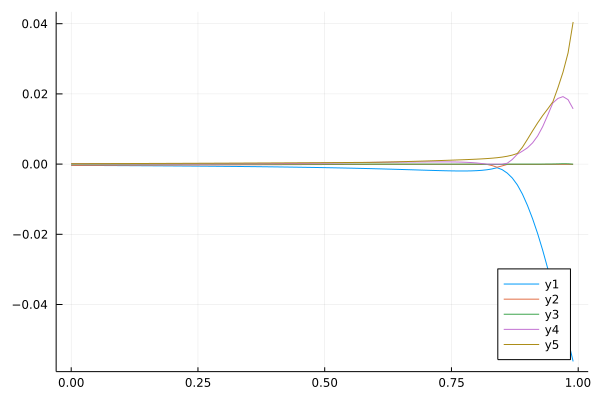

In [128]:
plot(legend=:bottomright)
for i in 1:5
    plot!(v,real.(ET[i,:])
        #,ylims=(-0.01,0.001)
    )
end
current()

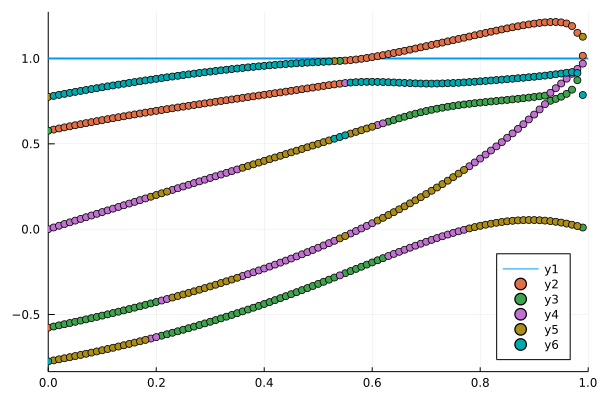

In [106]:
one(x)=1
plot(one,xlim=(0,1),legend=:bottomright, lw=2)
for i in 1:5
    scatter!(v,imag.(ET[i,:]))
end
current()